# Time Series Analysis of Toronto Temperature Data
### Sebastian Lech
In this notebook we explore a time series of Toronto temperatures, fit a model under the Box-Jenkins framework and evaluate its performance in advising what to wear outside based on the temperature. Data is gathered from https://climate.weather.gc.ca/ and steps on how to obtain it are outlined below.  After the data has been gathered, we explore it, discuss the notion of seasonality in temperature forecasting, fit a model and then compare forecasts to observed data.
### Sections
1. Gathering Data
2. Exploratory Analysis
3. Assessing Stationarity
4. Model Fitting
5. Forecasts & Perfornamce

### Purpose
The purpose of this analysis is an exercise in model fitting; an application of the Box-Jenkins framework.  Weather is a very complex phenomena and to model it accurately requires far more comprehensive a report than what is delivered here.  Instead, this notebook focuses on the progression of a traditional Box-Jenkins analysis (which can be taken and applied to other ARMA models), and serves as a jumping off point into weather analysis.  

# 1. Gathering Data
Before we can perform any sort of analysis, we need data.  Luckily, the Government of Canada provides an abundance of temperature records for most major cities across Canada.  Data can be explored at https://climate.weather.gc.ca/historical_data/search_historic_data_e.html which provides various weather metrics for stations located throughout a selected city.  In spite of the seemingly abundant results, station data is rather unorganized and data for certain stations can range anywhere from hourly temperatures between 1953-1969 to monthly temperatures between 1840-2006.  Since a group of stations within a particular region will not have data that matches for a specified timeframe we pick a single station and base our analysis using only its data.  Documenation on data retrieval is provided by the Government of Canada here https://drive.google.com/drive/folders/1WJCDEU34c60IfOnG4rv5EPZ4IhhW9vZH which contians a csv with geographical station information.  Since it has clean records of recent data and its proximity to downtown Toronto, we opt for the Toronto City station (ID: 31688) for our analysis.

<!-- ![title](Rplot.png) -->
<img src="Rplot.png" alt="Drawing" style="width: 900px;"/>

The documentation located in the google drive above also provides a simple bash script to retrieve the weather data.  After a slight modification, the following can be used to gather the data:

```
#!/bin/bash
for year in `seq 2002 2021`
do
    wget -O "${year}_daily_temperature_31688.csv" "https://climate.weather.gc.ca/climate_data/bulk_data_e.html?format=csv&stationID=31688&Year=${year}&Month=1&Day=14&timeframe=2&submit= Download+Data"
done

```
which will create 20 separate csv files, each of whom contain daily weather data for their respective year.  To avoid having to merge each file using R we can append their contents to a single file containing all year's data using shell
```
head -n 1 2002_daily_temperature_31688.csv > 2002_2021_daily_temps.csv && tail -n+2 -q *.csv >> 2002_2021_daily_temps.csv
```

# 2. Exploring Data
Now that we have temperature data we can begin to explore it.  Before we start, however, we should outline exactly how we plan to use the data.  Above we gathered roughly 20 years worth of data, which is a lot, and the steps of the analysis don't really change if we only had, say, 5 years worth of data.  So, instead of using all the data, we will take the last 5 years and partition it into training/test sets (95/5 split), fit a model using the training set and then evaluate our forecasts using the test set.  

In [2]:
# some useful packages
library(ggplot2)
library(lubridate)
library(dplyr)
library(astsa)
library(TSA)
library(glue)
library(gdata)
library(tseries)
library(forecast)
library(Metrics)
library(gridExtra)
options(repr.plot.width=15, repr.plot.height=8)

In [3]:
weather_data <- read.csv('data/2002_2021_daily_temps.csv', header=TRUE)   # read data
names(weather_data)[c(1, 2, 10, 12, 14)] = c('longitude', 
                                             'latitude', 
                                             'max.temp', 
                                             'min.temp', 
                                             'mean.temp')
temp_data <- weather_data[c(5, 6, 7, 8, 10, 12, 14)] # only keep temperatures                   
temp_data$Date.Time <- as.Date(temp_data$Date.Time, format="%Y-%m-%d")  
temp_data$Month <- month.abb[temp_data$Month]
start <- as.Date('2017-01-01', format('%Y-%m-%d'))
end <- as.Date('2021-05-07', format('%Y-%m-%d'))
working_temps <- temp_data[temp_data[, 1] >= start & temp_data[, 1] <= end, ]

As with any datasets, there will be some inconsistencies in the data.  The first thing we want to check for is missing data.  Below we notice that there are 34 days missing mean temperatures, located throughout the data set.  Rather than manually looking up 34 seperate days from other sources of weather data we will linearly interpolate to fill in the blanks.

In [4]:
working_temps[!complete.cases(working_temps),] # identify missing (NA) mean temps

,Date.Time,Year,Month,Day,max.temp,min.temp,mean.temp
,<date>,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>
5544,2017-03-06,2017,Mar,6,4.9,NA,NA
5580,2017-04-11,2017,Apr,11,NA,11.3,NA
5617,2017-05-18,2017,May,18,NA,18.4,NA
5621,2017-05-22,2017,May,22,NA,NA,NA
5622,2017-05-23,2017,May,23,21.8,NA,NA
5628,2017-05-29,2017,May,29,NA,14.7,NA
5637,2017-06-07,2017,Jun,7,NA,NA,NA
5782,2017-10-30,2017,Oct,30,NA,5.9,NA
5790,2017-11-07,2017,Nov,7,NA,4.0,NA


In [5]:
# split the dataset into train/test (95/5)
ndays <- length(working_temps$Year) # number of days, 1588
working_temps$mean.temp <- round(approx(1:ndays, working_temps$mean.temp, n=ndays)$y, 1) # linearly interpolate missing dates
split <- floor(ndays*0.95) 
train <- working_temps[1:split, ]   
test <- working_temps[(split+1):ndays, ]

### Seasonality
Now we can take a look at the time series and how temperatures are distributed.  The first thing to notice from the time series is that there appears to be seasonality in the data.  Of course this makes sense given that we are looking at temperature data, however, there is some subtlety in what we are observing.  In the context of time series analysis, seasonality refers to an autoregressive influence that occurs periodically.  For example, had we done this analysis on monthly data it would make sense that the temperature in Jan 2020 would be a good indicator of the temperature in Jan 2021, hence we would expect to fit a seasonal model whose autoregressive influence occurs every 12 months.  However, it does not seem reasonable to expect that the temperature on Jan 01, 2020 will be a good indicator of the temperature on Jan 01, 2021.  This is somewhat unintuitive, proceeding with a nonseasonal model for what we know is a seasonal phenomena, but we will see how we can exploit this feature later on in the analysis.  For now we explore the data a little more and confirm that it is clean enough to move forward with model fitting.

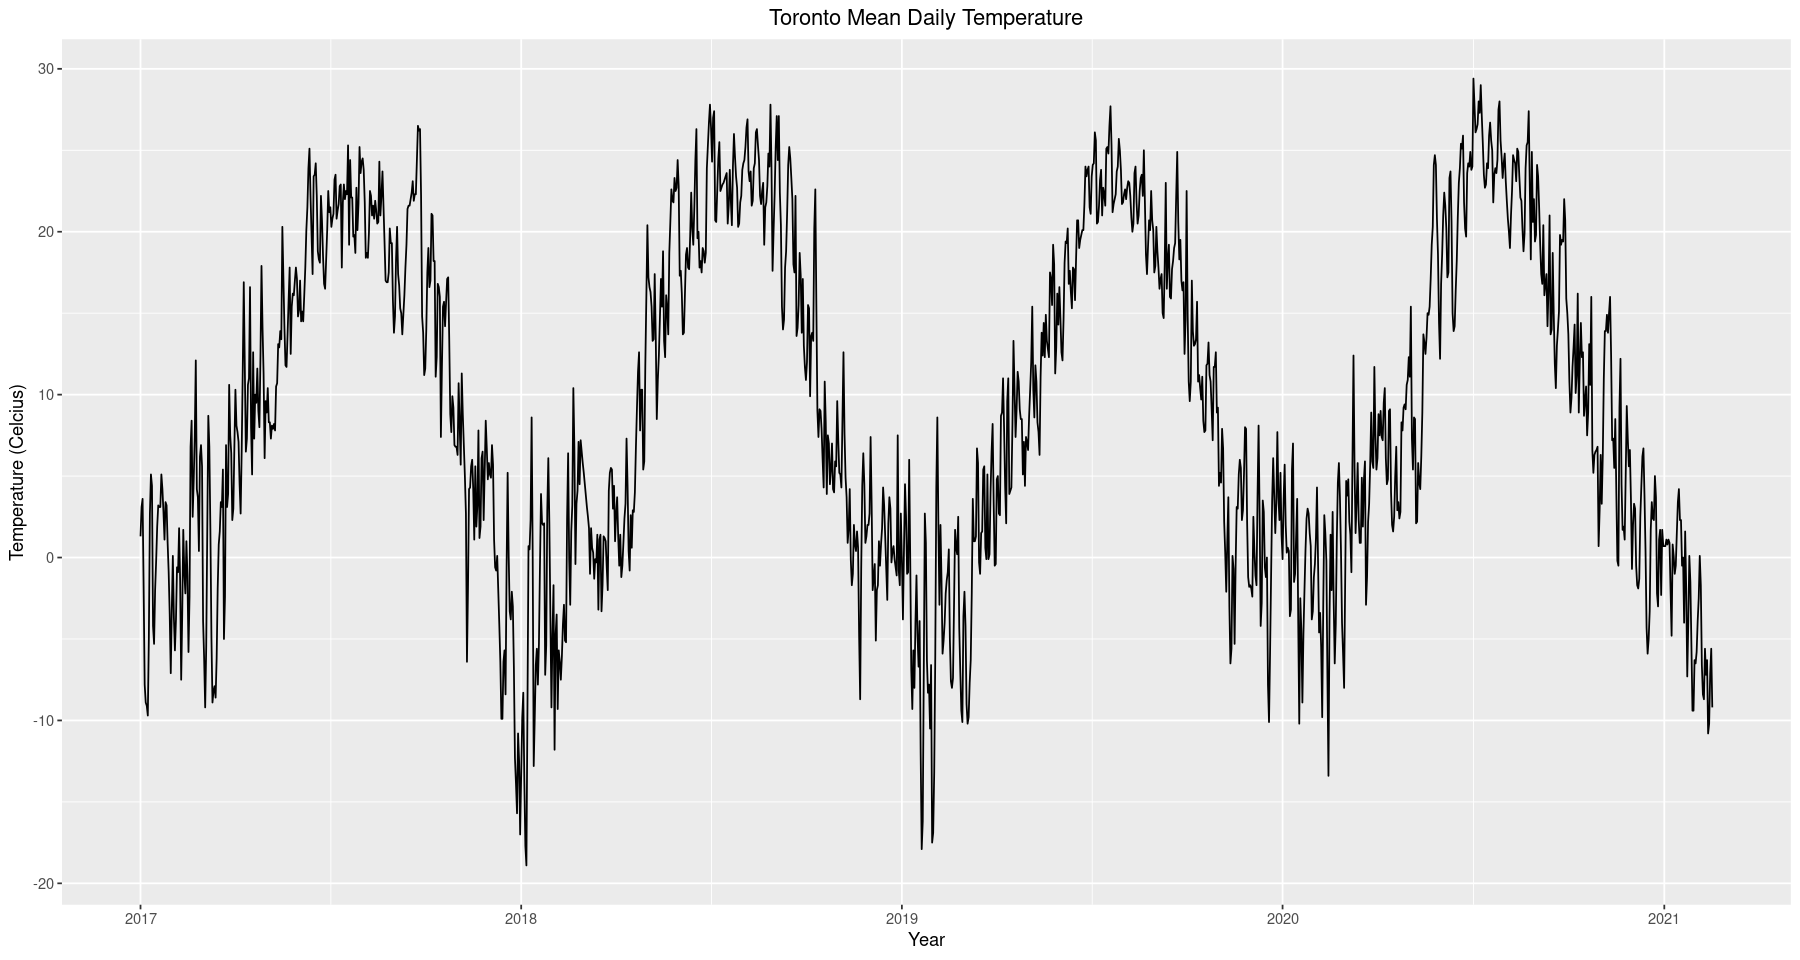

In [6]:
ggplot(data=train, aes(x=Date.Time, y=mean.temp)) + 
        geom_line() +
        ggtitle('Toronto Mean Daily Temperature') + 
        xlab('Year') + ylab('Temperature (Celcius)') +
        theme(plot.title = element_text(hjust = 0.5))

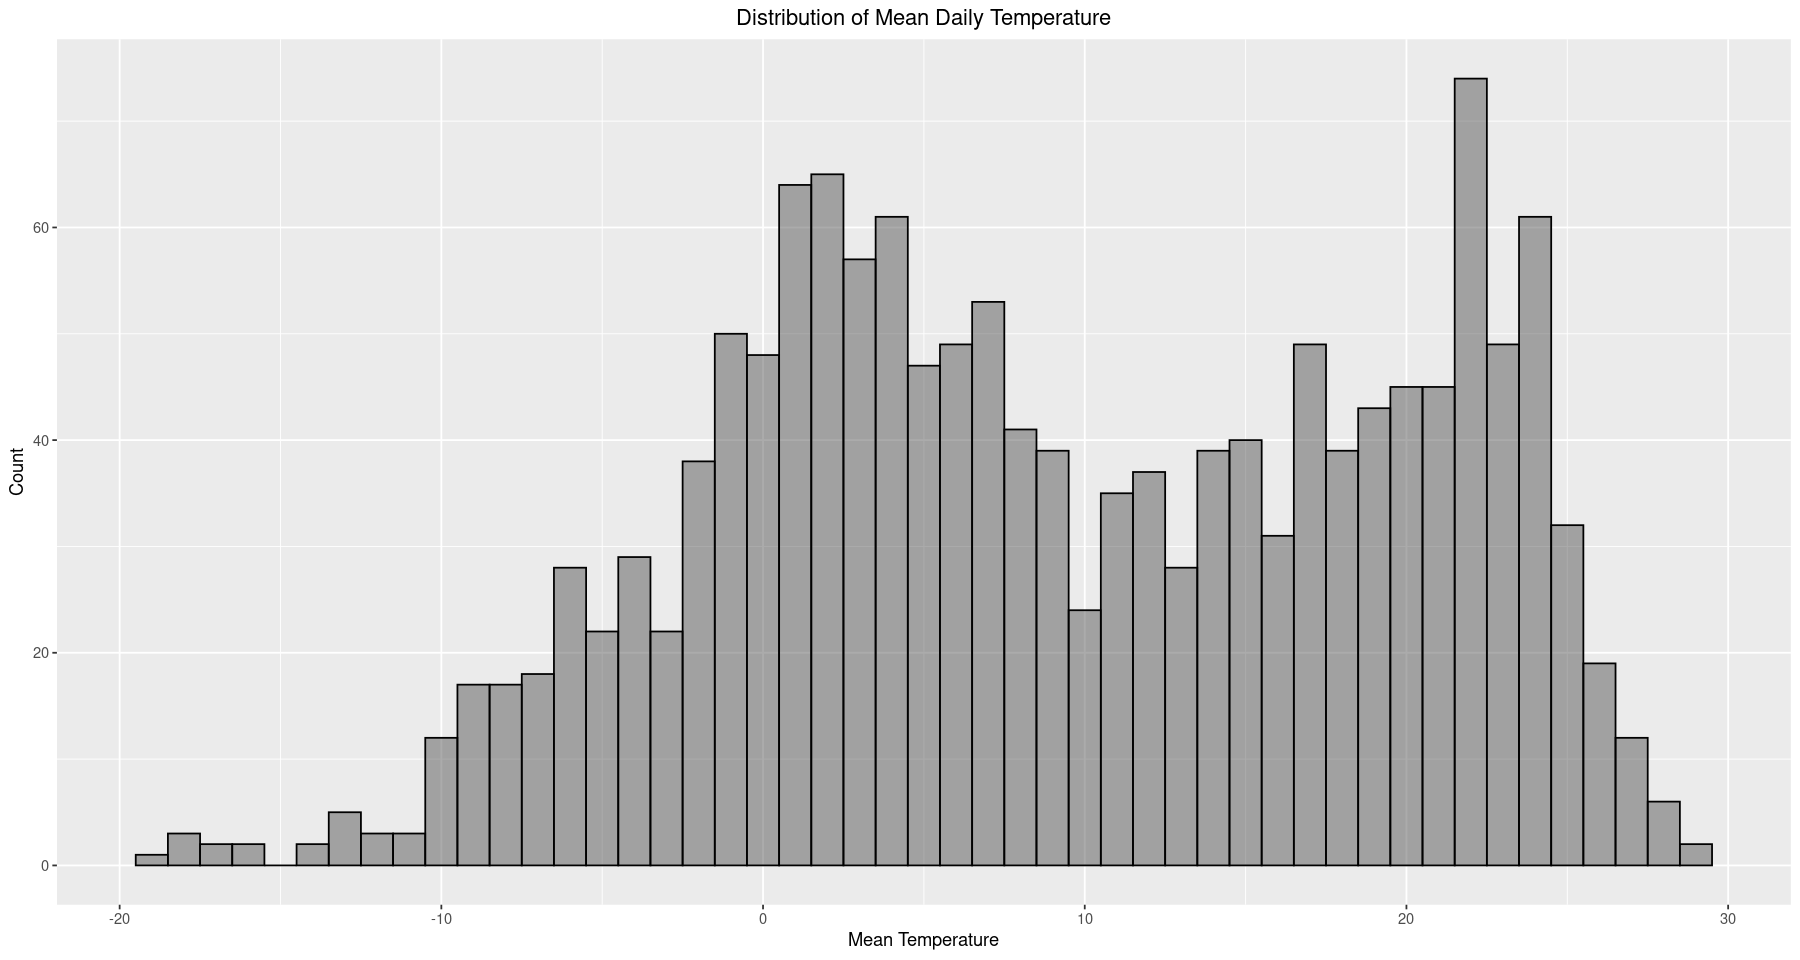

In [7]:
ggplot(data=train, aes(x=mean.temp)) + 
        geom_histogram(binwidth=1, alpha=0.5, color='black') +
        ggtitle('Distribution of Mean Daily Temperature') + 
        xlab('Mean Temperature') + ylab('Count') +
        theme(plot.title = element_text(hjust = 0.5))

The purpose of this analysis is to apply the Box-Jenkins framework and fit an ARMA model to the time series, of which, a requirement is stationary data.  As we noted earlier, the data seems to have some seasonality in it.  For instance, we see below that every year, between June and August, temperature will be a lot higher than in the other months.  Again, this is not news, since we know the summer is the warmest time of the year, but it still presents a problem in that seasonality means the data is not stationary.  Even though this observation is well founded it's good practice to reinforce our argument statistically and assess the technical aspects of our conjecture.  

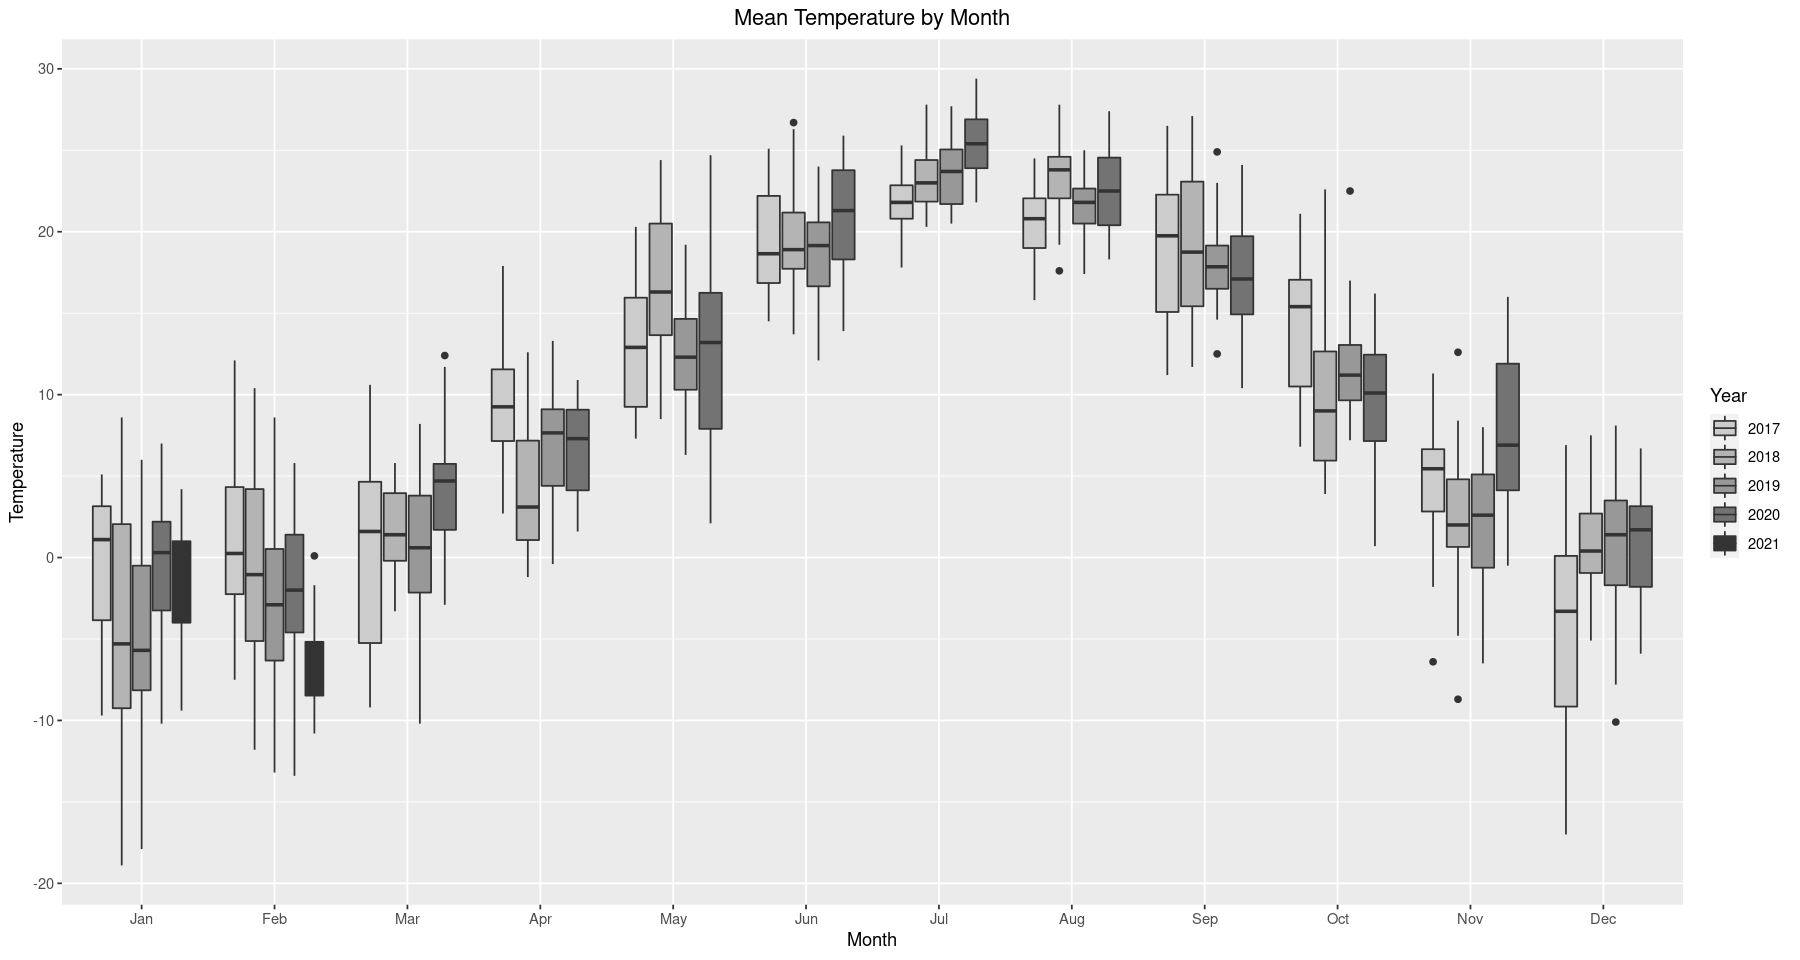

In [8]:
ggplot(train) + geom_boxplot(aes(x=factor(Month, levels=month.abb), y=mean.temp, fill=as.character(Year))) + 
                scale_fill_grey(start = 0.8, end = 0.2) + 
                ggtitle('Mean Temperature by Month') +
                xlab('Month') + ylab('Temperature') +
                theme(plot.title = element_text(hjust = 0.5)) + labs(fill='Year')

# 3. Assessing Stationarity
To assess stationarity, the first thing we want to look at is autocorrelation.  The ACF plot (top) decays very slowly and Partial ACF (bottom) has significant lags beyond what we would expect in stationary data.  Both plots exhibit strong indicators that the data is in fact, not stationary.  Likewise, we can employ the Augmented Dickey-Fuller (ADF) test to check if our nonstationarity conjecture is actually wrong.  There is plenty of reason to think this will not be the case, hence we expect to observe an insignificant p-value.  However, we should be careful because insignificant test statistics don't really allow us to conclude anything, we simply fail to reject the test's null hypothesis (in our case, that the time series is not stationary).  But given our experience of seasonal temperatures and the strong indicators of nonstationarity exhibited by the ACF and PACF tests we feel confident that the data is not stationary and so, we must fix that.

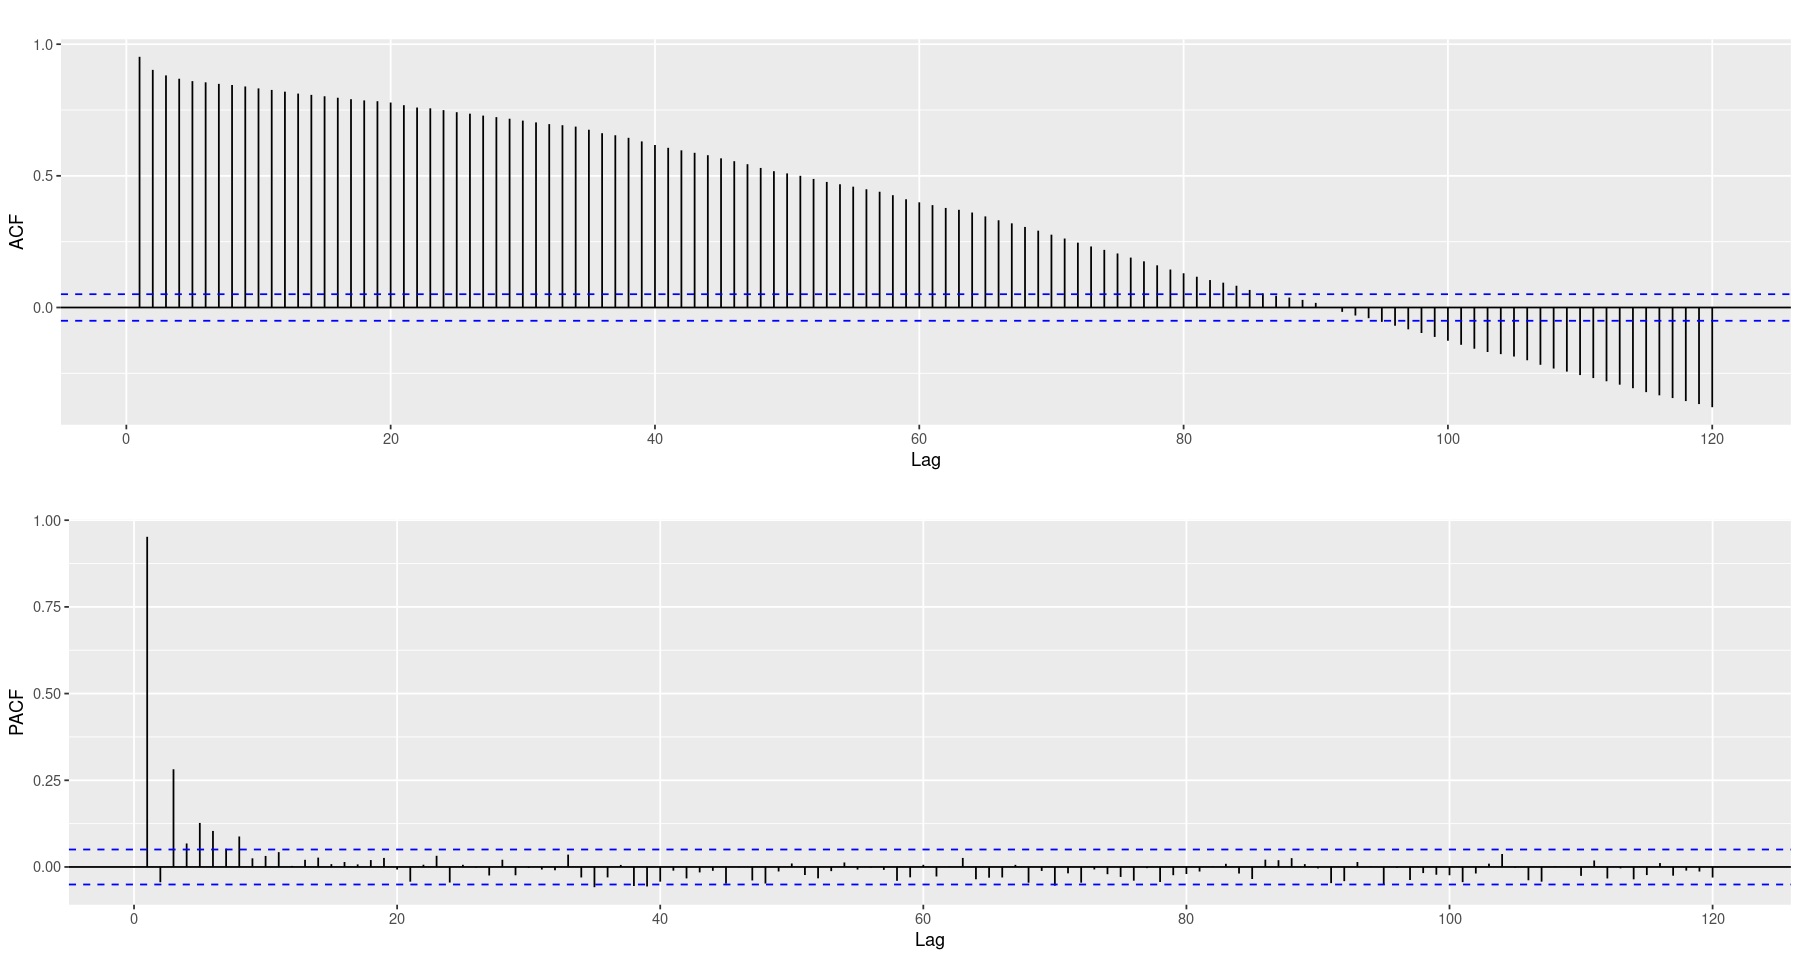

In [89]:
acf <- ggAcf(train$mean.temp, lag.max=120) + ggtitle('')
pacf <- ggPacf(train$mean.temp, lag.max=120) + ggtitle('')
grid.arrange(acf, pacf, nrow=2)

In [90]:
adf.test(train$mean.temp) 


	Augmented Dickey-Fuller Test

data:  train$mean.temp
Dickey-Fuller = -2.1489, Lag order = 11, p-value = 0.5153
alternative hypothesis: stationary


As we expected, the test is not significant.  So, up to this point we have no reason to believe the data might be stationary but in order to apply the Box-Jenkins framework stationarity is a requirement.  We discuss how to fix this below.  

# 3. Model Fitting
As discussed above we will not be moving forward with a seasonal ARMA model, however we can still exploit the time series seasonality in fitting a model.  Recall that the time series exhibits a periodic progression, very similar to a cosine curve.  In fact, we can extract the seasonality we observe by fitting a cosine model via least squares to represent the deterministic portion of the time series.  After we remove this deterministic portion (by subtracting it away) we will be left with the stochastic portion which, if stationary, we can model under the Box-Jenkins framework.  To proceed we might want to fit the following model,

$$\mu_t = \beta \cos\left(\frac{2\pi t}{365} + \Phi\right)$$

Where 365 represents the period (yearly), $\beta$ the amplitude of the curve and $\Phi$ manages the origin of the curve. Fitting this curve is not straightforward because the parameters we need to estimate (in particular, $\Phi$) do not enter the equation linearly.  However, we can take advantage of the following trigonometric identity 

$$\cos(a+b) = \cos(a)\cos(b) - \sin(a)\sin(b)$$

That is, we take $a=2\pi t/365$ and $b=\Phi$ so that

$$\begin{align}
\mu_t &= \beta \cos\left(\frac{2\pi t}{365} + \Phi\right) \\
&= \beta \left(\cos\left(\frac{2\pi t}{365}\right)\cos\Phi - \sin\left(\frac{2\pi t}{365}\right)\sin\Phi\right) \\
&= \underbrace{\beta\cos\Phi}_{\beta_1}\cos\left(\frac{2\pi t}{365}\right) \underbrace{- \beta\sin\Phi}_{\beta_2}\sin\left(\frac{2\pi t}{365}\right)\\
&= \beta_1\cos\left(\frac{2\pi t}{365}\right) + \beta_2\sin\left(\frac{2\pi t}{365}\right)
\end{align}$$
Likewise, notice that
$$\beta_1^2+\beta_2^2 = \beta^2(\cos^2\Phi+\sin^2\Phi) = \beta^2\iff \beta = \sqrt{\beta_1^2+\beta_2^2}$$
$$\frac{\beta_1}{\beta_2} = -\frac{\sin\Phi}{\cos\Phi} = -\tan(\Phi)\iff \Phi = \tan^{-1}\left(\frac{\beta_1}{\beta_2}\right)$$
which means we can determine $\mu_t$ by estimating $\beta_1, \beta_2$ using a linear regression in which $\cos\left(\frac{2\pi t}{365}\right)$ and $\sin\left(\frac{2\pi t}{365}\right)$ are our regressors (recall that linear regression requires the model be linear in the coefficients, not in the regressors).

In [10]:
# we take advantage of time series objects a lot in the 
# analysis that follows, which allows us to specify
# a start date and a frequency.  Note that frequency
# is 365.25 because 2020 was a leap year.
temps_ts <- ts(train$mean.temp, start=c(2017, 1), f=365.25) # time series object
X <- harmonic(temps_ts, 1)          # matrix of harmonic regressors
x1 <- data.frame(X)$cos.2.pi.t      # predictor 1
x2 <- data.frame(X)$sin.2.pi.t      # predictor 2
cos_model <- lm(temps_ts ~ x1 + x2)
summary(cos_model)
train$cos_model <- as.double(fitted(cos_model))


Call:
lm(formula = temps_ts ~ x1 + x2)

Residuals:
     Min       1Q   Median       3Q      Max 
-16.2120  -2.6323  -0.0664   2.8596  13.7209 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   9.8019     0.1063   92.19   <2e-16 ***
x1          -12.1171     0.1489  -81.37   <2e-16 ***
x2           -5.0628     0.1518  -33.36   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 4.125 on 1505 degrees of freedom
Multiple R-squared:  0.839,	Adjusted R-squared:  0.8387 
F-statistic:  3920 on 2 and 1505 DF,  p-value: < 2.2e-16


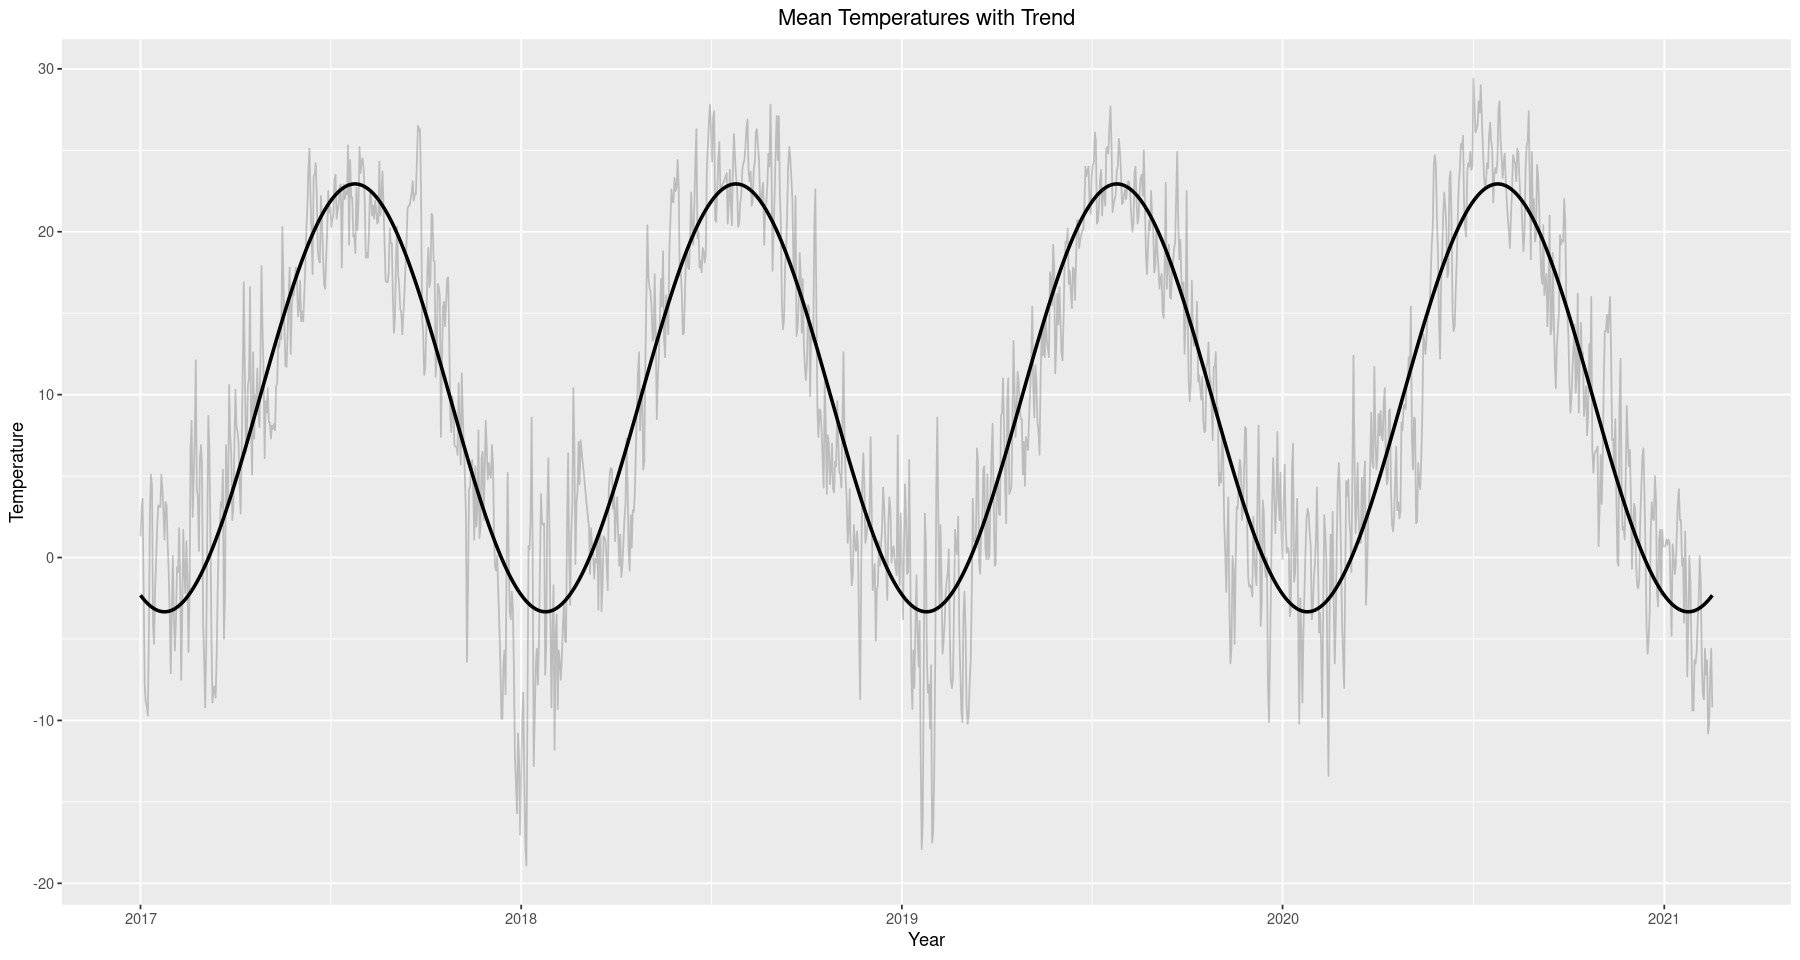

In [11]:
ggplot() + geom_line(data=train, aes(x=Date.Time, y=mean.temp), alpha=0.2) + 
        geom_line(data=train, aes(x=Date.Time, y=cos_model), size=1, color=1) +
        ggtitle('Mean Temperatures with Trend') + 
        xlab('Year') + ylab('Temperature') +
        theme(plot.title = element_text(hjust = 0.5))
        

After fitting the cosine model to represent the deterministic portion we extract it by taking the difference between it and the original.  The resulting time series appears to be random noise, which we can confirm is stationary with a significant p-value in the ADF test below.  

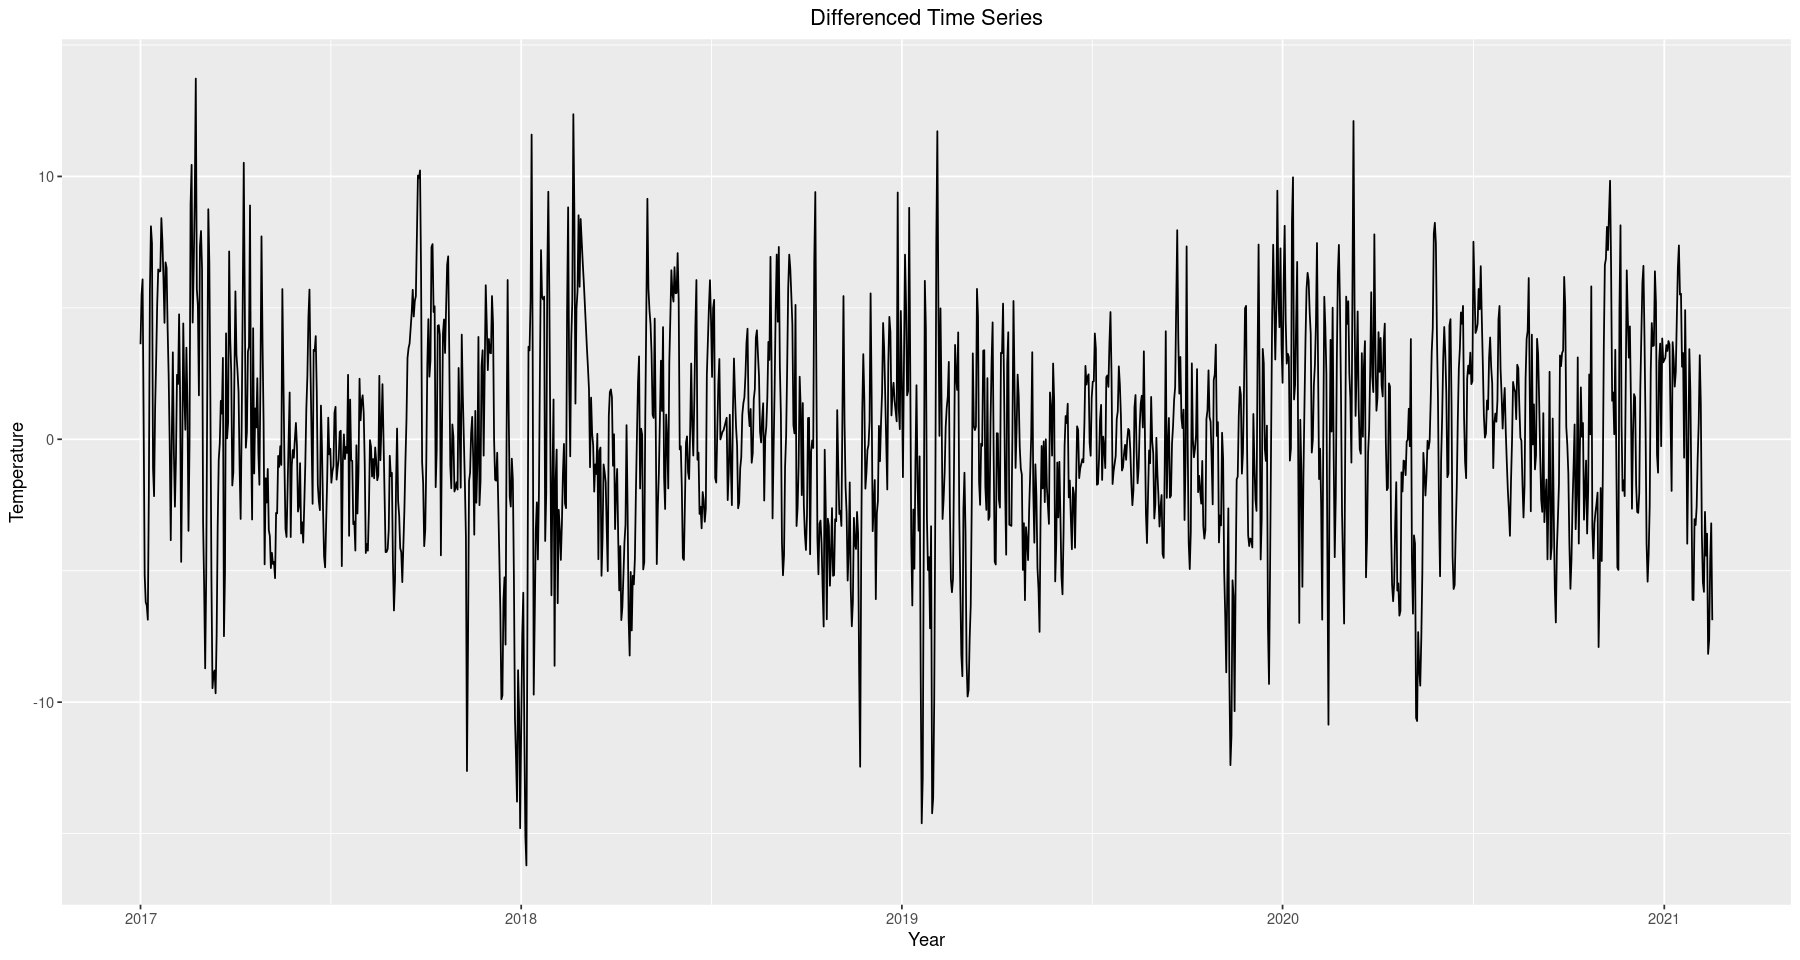

In [12]:
train$diff_model <- train[, 7] - train[, 8]  # difference between cos and original
ggplot(data=train, aes(x=Date.Time, y=diff_model)) + geom_line() +
        ggtitle('Differenced Time Series') +
        xlab('Year') + ylab('Temperature') + 
        theme(plot.title = element_text(hjust = 0.5))

In [13]:
adf.test(train$diff_model)

Warning message in adf.test(train$diff_model):
"p-value smaller than printed p-value"



	Augmented Dickey-Fuller Test

data:  train$diff_model
Dickey-Fuller = -8.517, Lag order = 11, p-value = 0.01
alternative hypothesis: stationary


Since we have a stationary time series we can apply the Box-Jenkins framework.  Our goal here is to fit an $ARMA(p,q)$ model and use our data to estimate $p$ and $q$.  The first place we start is with the ACF and PACF plots to get an idea of the nature of the data.  We see the ACF decay much quicker but notice that it does not cut off distinctly anywhere; a strong indicator of an autoregressive component.  Likewise, the PACF cuts off at lag 3, indicating the order of the AR term could be 3.  However, since we are most likely looking at a mixed model, we will employ the extended ACF to indicate feasible models.

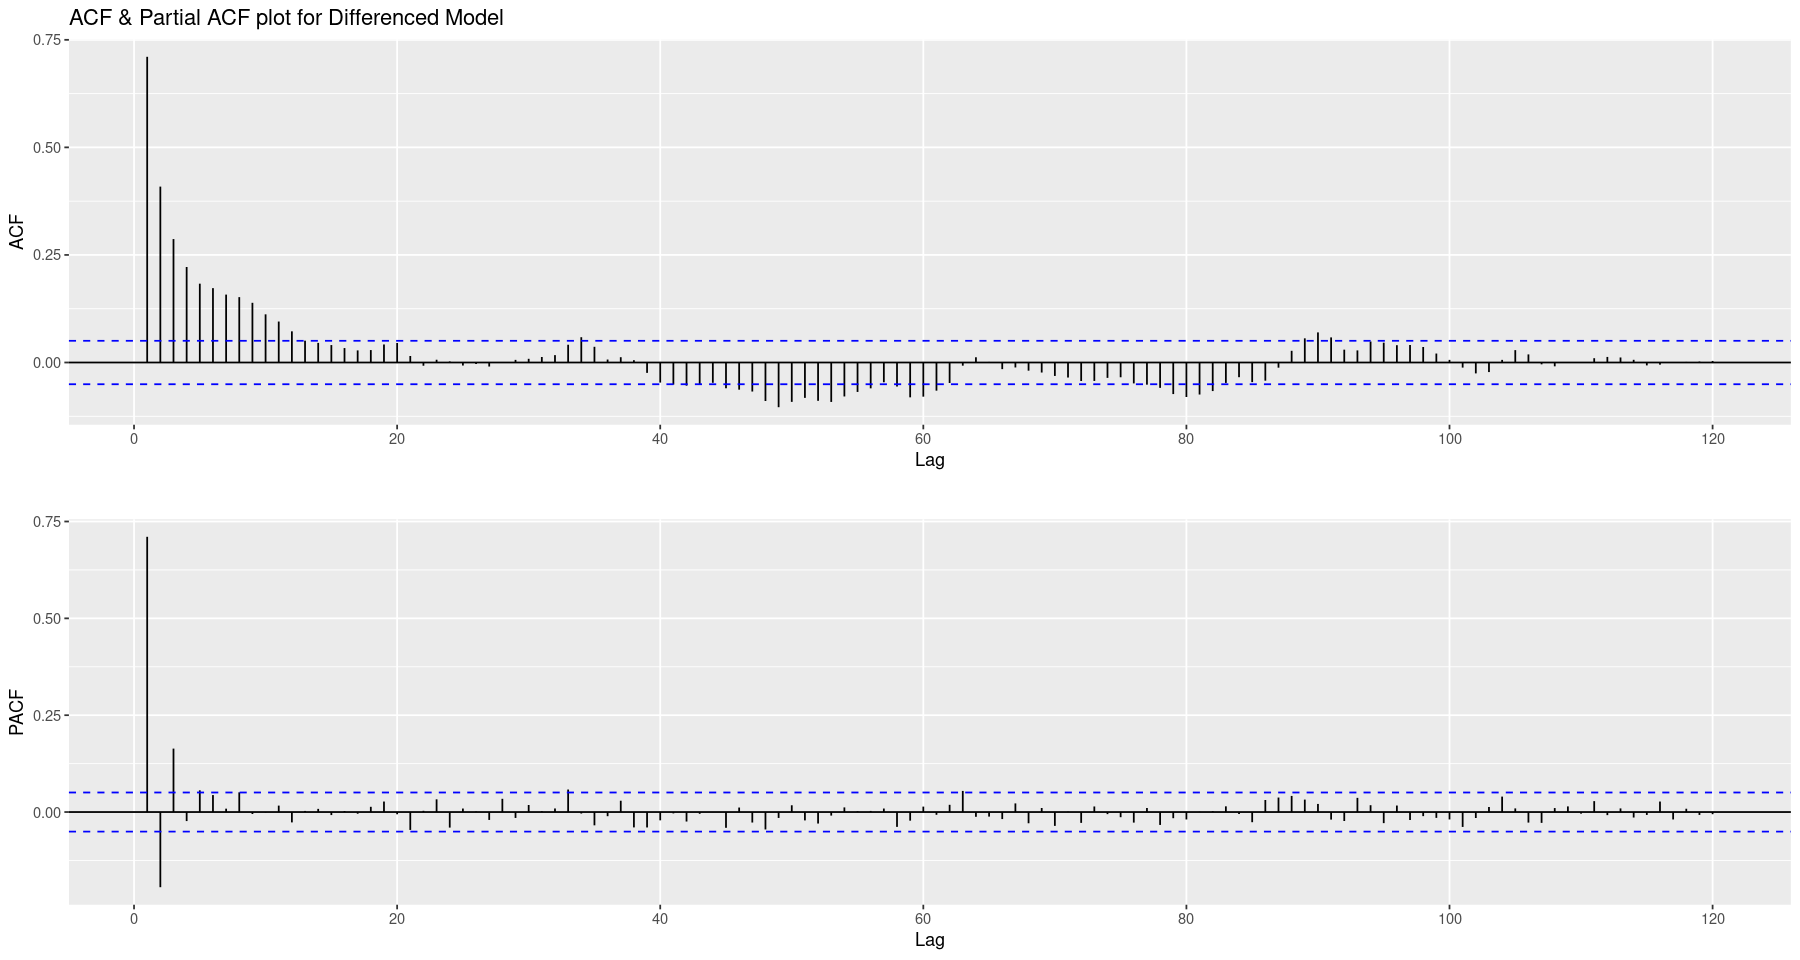

In [97]:
acf <- ggAcf(train$diff_model, lag.max=120) + ggtitle('ACF & Partial ACF plot for Differenced Model')
pacf <- ggPacf(train$diff_model, lag.max=120) + ggtitle('')
grid.arrange(acf, pacf, nrow=2)

In [99]:
eacf(train$diff_model, ar.max=5, ma.max=5)
# o is feasible
# x is not feasible

AR/MA
  0 1 2 3 4 5
0 x x x x x x
1 x x x o o o
2 x x o o o o
3 x x x o o o
4 x x x x o o
5 x x x x o o


Above we have a chart of the Extended ACF which indicates feasible models (o).  In the cell below we fit a collection of different models, record their AIC and BIC results and compare.  Using both of these evaluation criteria we want to take a feasible model with the most favorable AIC and BIC results.  The diagnostics of each model were also compared, however are omitted because there are many of them.  Instead we elect to model using an $ARMA(3, 3)$ process and include its diagnostics below.  

In [19]:
# evaluate a collection of possible models
diff_model.aic <- matrix(0, 5, 5)
diff_model.bic <- matrix(0, 5, 5)
for (i in 0:4) for (j in 0:4){
    noise.fit <- arima(train$diff_model, order=c(i, 0, j), method="ML", include.mean = TRUE, optim.control = list(maxit=1000))
    diff_model.aic[i+1, j+1] <- noise.fit$aic
    diff_model.bic[i+1, j+1] <- BIC(noise.fit)
}

In [20]:
sort(unmatrix(diff_model.aic, byrow=FALSE))[1:10]
sort(unmatrix(diff_model.bic, byrow=FALSE))[1:10]

r3:c3    r2:c4    r3:c4    r2:c5    r4:c4    r5:c3    r5:c4    r5:c5 
7389.027 7389.961 7391.005 7391.605 7392.055 7392.871 7393.015 7393.167 
   r4:c5    r3:c5 
7393.586 7393.686

r3:c3    r4:c1    r2:c4    r2:c3    r2:c2    r3:c2    r4:c2    r5:c1 
7422.938 7423.530 7423.872 7424.136 7427.530 7429.085 7429.258 7430.040 
   r3:c4    r2:c5 
7430.234 7430.835

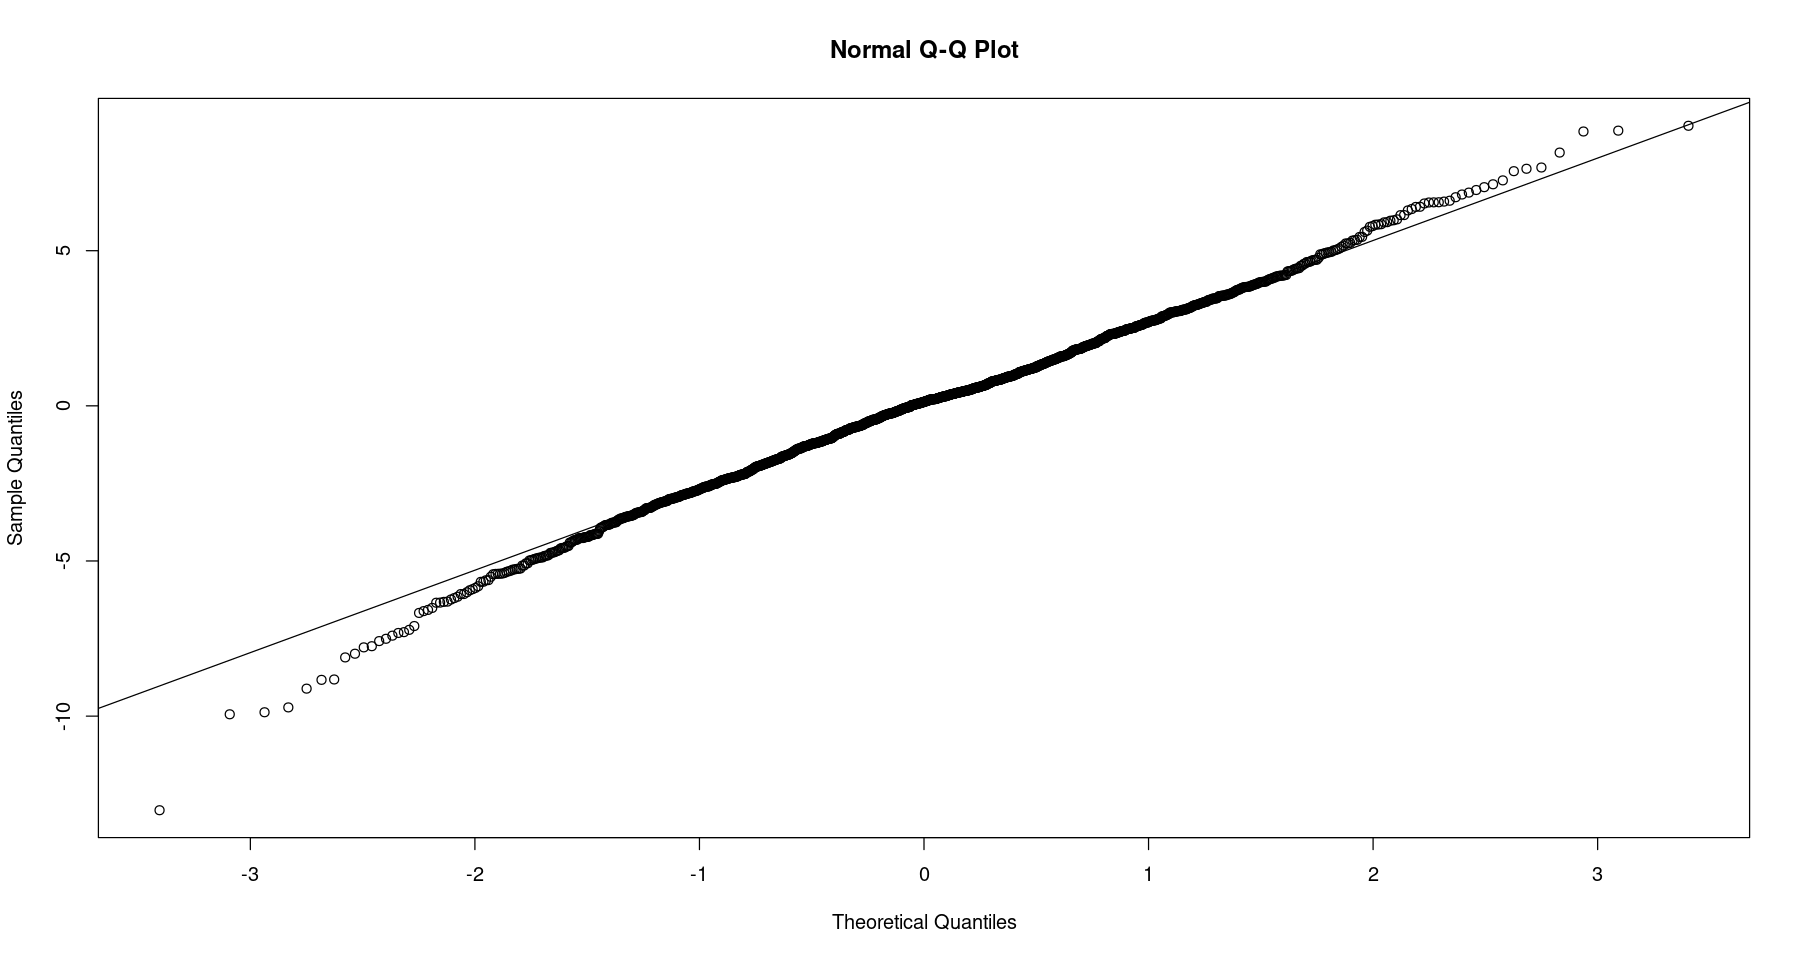

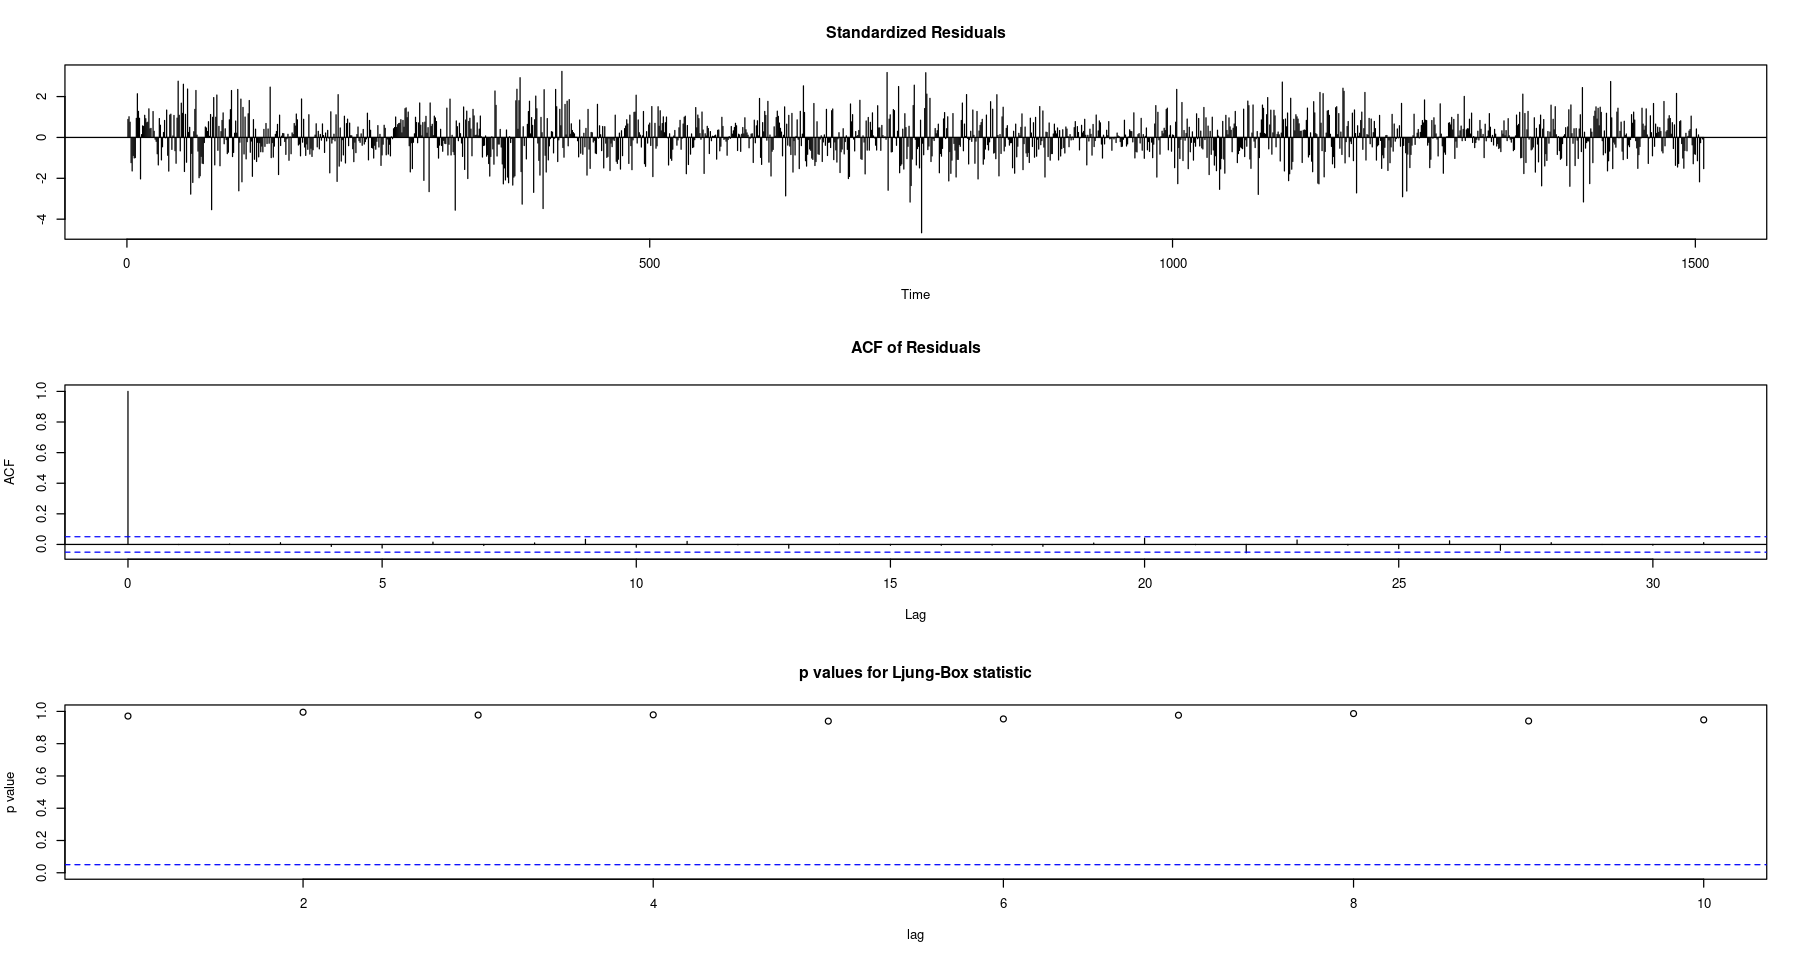

In [22]:
# diagnostics
noise.fit <- arima(train$diff_model, order=c(3, 0, 3), method="ML", include.mean = TRUE)  # ARMA(3,3) model
model.res <- residuals(noise.fit)
qqnorm(model.res)
qqline(model.res)
tsdiag(noise.fit)

Near linearity between the theoretical and sample quantiles suggest that the errors are normally distributed.  The time plot of the residuals looks like a white noise process and the ACF does not indicate any significant lags, hence are uncorrelated.  We also have large p-values for the LB statistic, another strong indicator of uncorrelated errors.  These are all signs that an $ARMA(3,3)$ fits the differenced time series nicely.    

# 5. Forecasting
We are now ready to evaluate the performance of our model by forecasting the duration of the test set.  Recall that our train/test split was 95/5, leaving us with an 80 day period to forecast.  Once forecasts are produced we evaluate accuracy with the error metric Root Mean Square Error (RMSE).  Forecasting requires extending both the deterministic and stochastic portions of the time series then recombining them, essentially unwinding the differencing we did earlier.   

In [15]:
# 1st day of test set, for time series object
test.day1 <- test[1, 1]
test.start.day <- as.numeric(strftime(test.day1, format = "%j")) 
s <- '{test.day1} is the {test.start.day}th day of the year'
print(glue(s))

2021-02-17 is the 48th day of the year


In [16]:
test.temps.ts <- ts(test$mean.temp, start=c(2020, test.start.day), f=365.25)
new_X <- harmonic(test.temps.ts, 1) # produce new set of predictor variables
pred_X <- data.frame(new_X)
colnames(pred_X) <- c("x1", "x2")
preds <- predict(cos_model, pred_X) # predict new vals for deterministic trend
test$cos_model <- preds # extended cosine curve
test <- test[, !(names(test) %in% c('cos_mode'))]

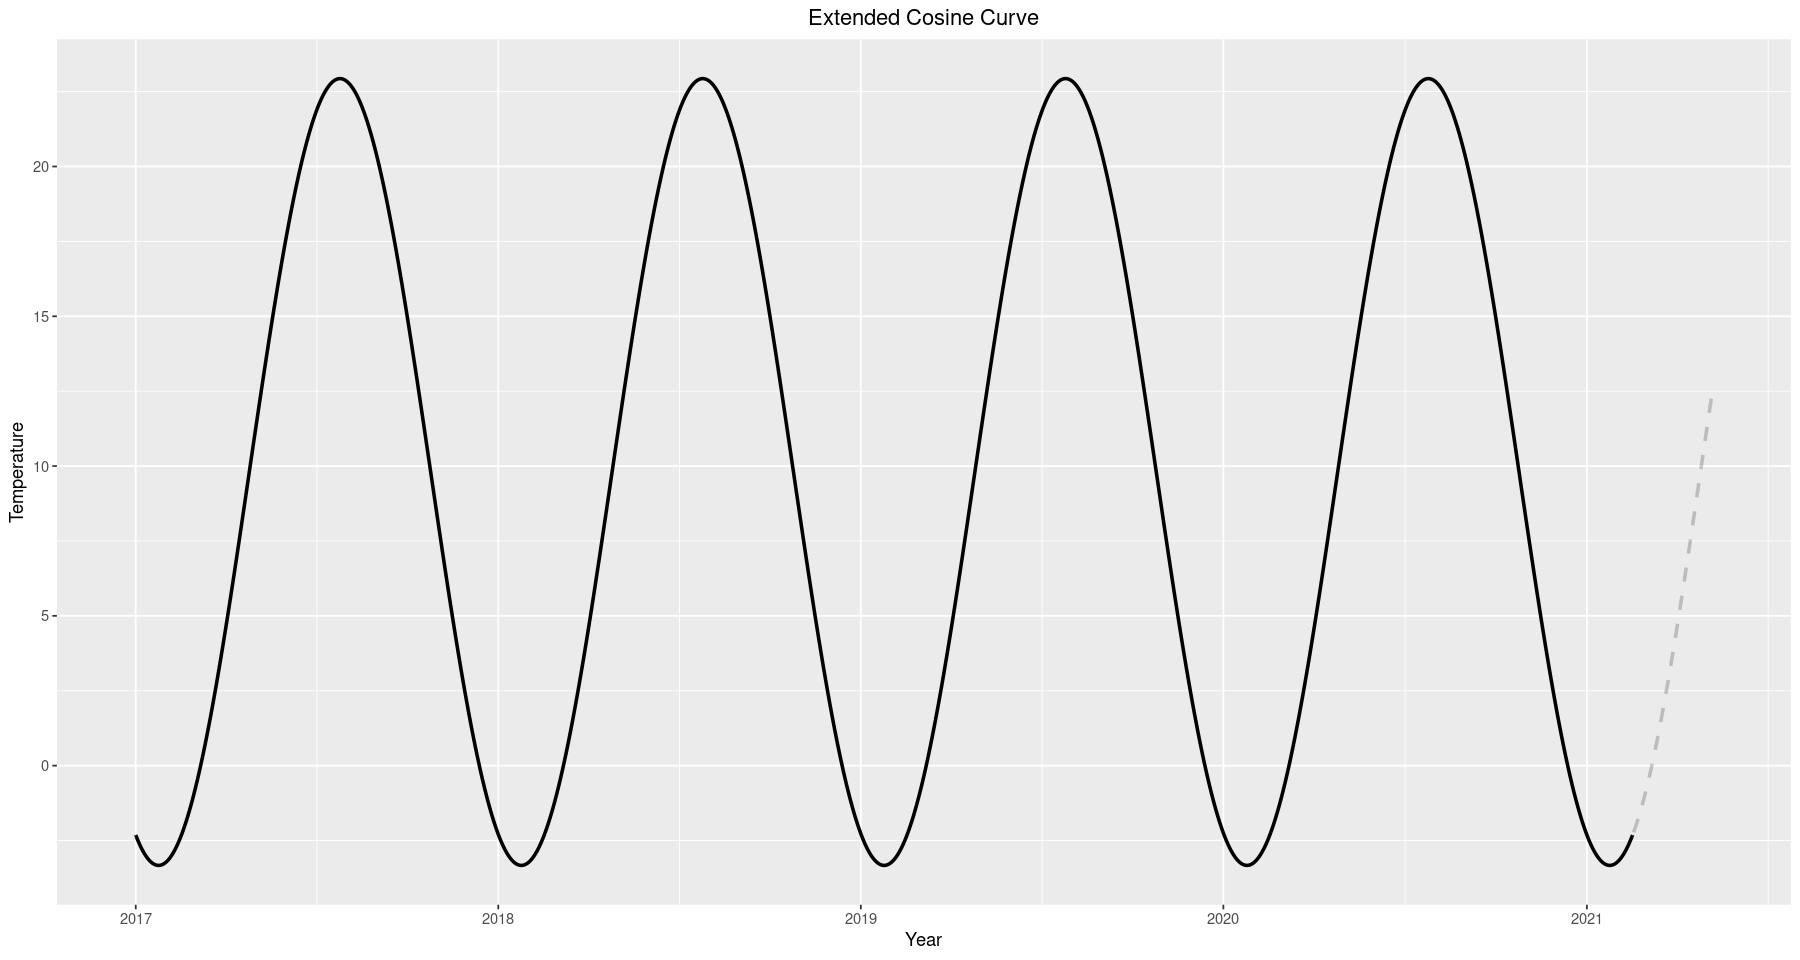

In [17]:
ggplot() + geom_line(data=train, aes(x=Date.Time, y=cos_model), size=1) + 
           geom_line(data=test, aes(x=Date.Time, y=cos_model), size=1, alpha=0.2, linetype='dashed') +
           ggtitle('Extended Cosine Curve') +
           xlab('Year') + ylab('Temperature') + 
           theme(plot.title = element_text(hjust = 0.5))

In [23]:
noise.forecast <- predict(noise.fit, 80)        # 80 days out
# keep track of error bounds
p_se <- noise.forecast$pred + noise.forecast$se # forecast + (p) standard error (se)
m_se <- noise.forecast$pred - noise.forecast$se # forecast - (m) standard error (se)

In [26]:
forecast.temps <- noise.forecast$pred + c(preds)        # recovered forecasts (deterministic + noise)
forecast.p.e <- forecast.temps + noise.forecast$se      # upper (+) error bound
forecast.m.e <- forecast.temps - noise.forecast$se      # lower (-) error bound 

In [27]:
# insert them into test dataframe
test$fc <- as.double(forecast.temps)
test$forecast.p.e <- as.double(forecast.p.e)
test$forecast.m.e <- as.double(forecast.m.e)

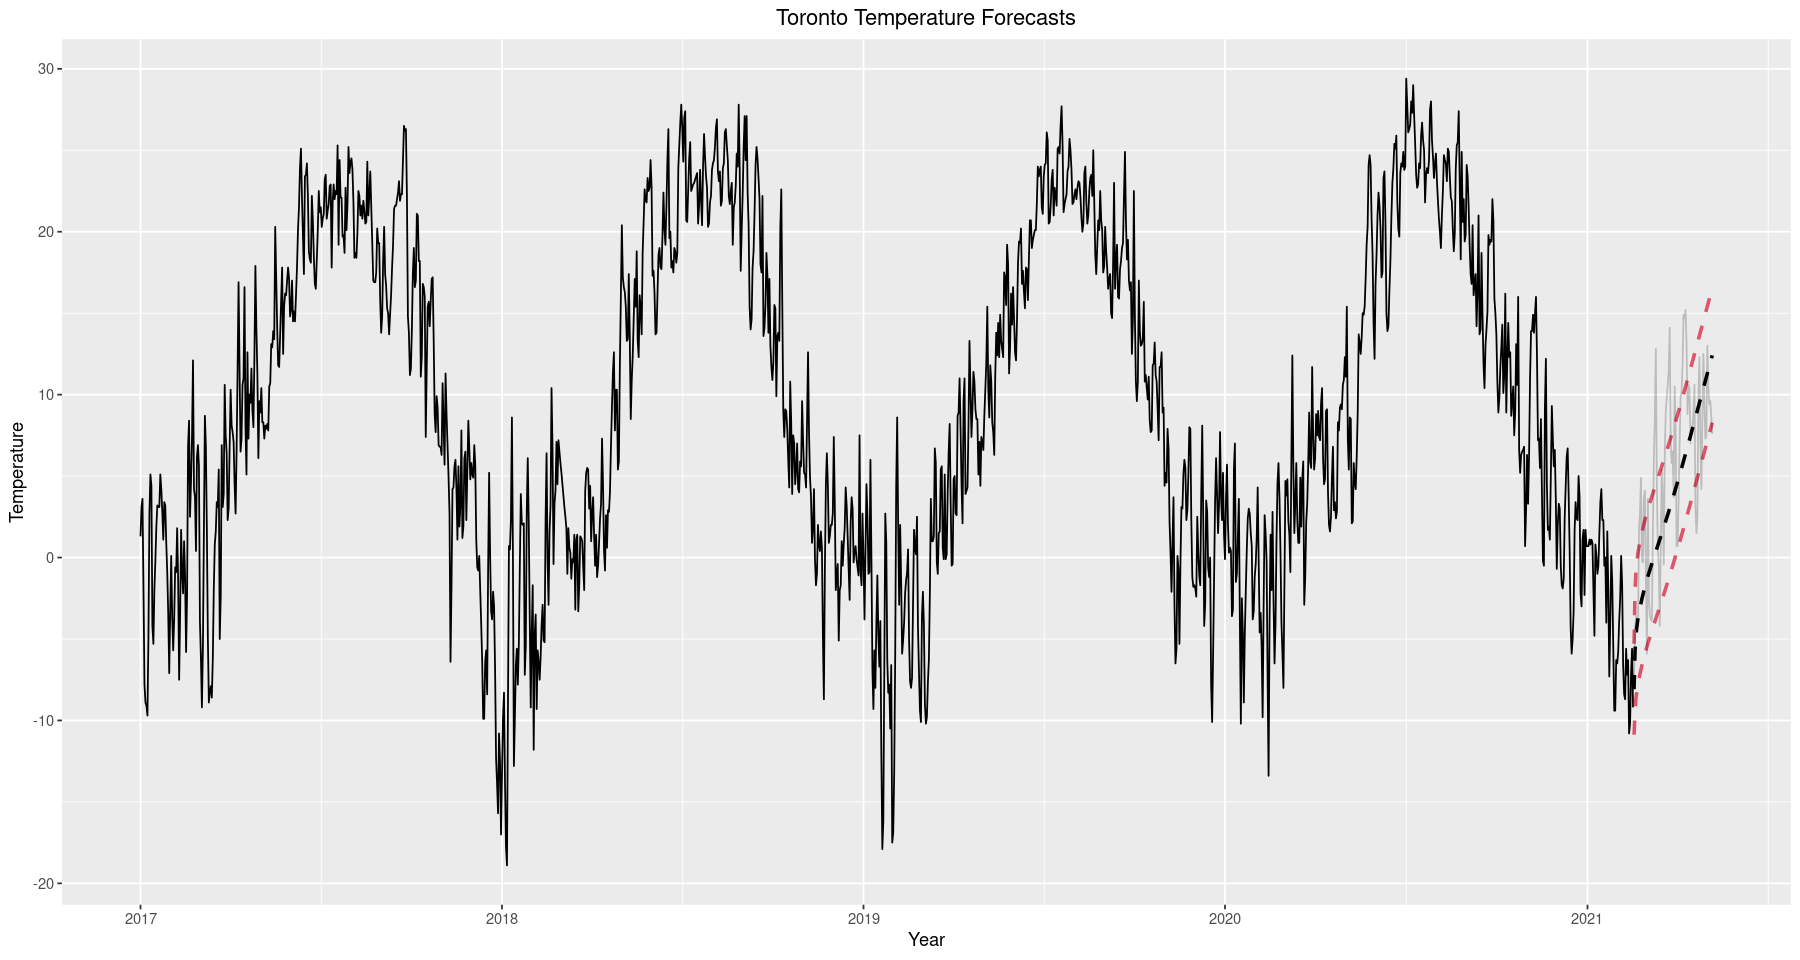

In [28]:
ggplot() + geom_line(data=train, aes(x=Date.Time, y=mean.temp)) + 
           geom_line(data=test, aes(x=Date.Time, y=fc), size=1, alpha=1, linetype='dashed') +
           geom_line(data=test, aes(x=Date.Time, y=forecast.p.e), alpha=1, color=2, linetype='dashed', size=1) +
           geom_line(data=test, aes(x=Date.Time, y=forecast.m.e), alpha=1, color=2, linetype='dashed', size=1) +
           geom_line(data=test, aes(Date.Time, mean.temp), alpha=0.2) +
           ggtitle('Toronto Temperature Forecasts') +
           xlab('Year') + ylab('Temperature') + 
           theme(plot.title = element_text(hjust = 0.5))

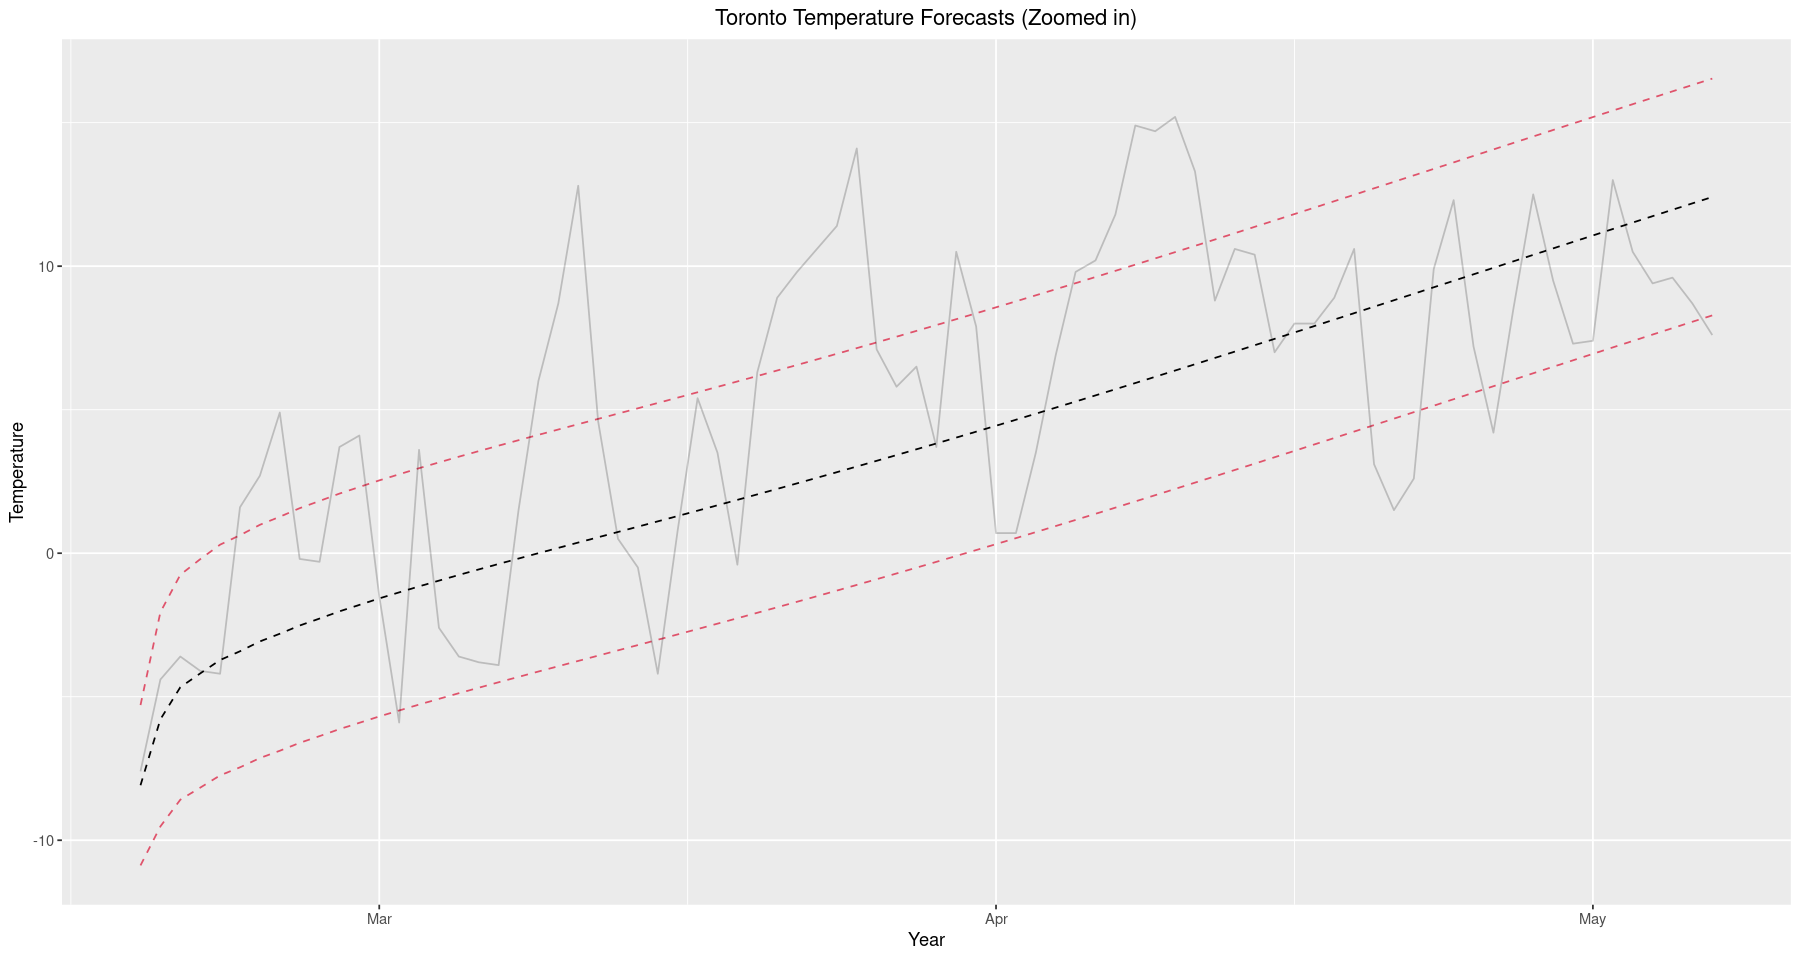

In [31]:
ggplot() + geom_line(data=test, aes(x=Date.Time, y=fc), linetype='dashed') + 
        geom_line(data=test, aes(x=Date.Time, y=forecast.p.e), color=2, linetype='dashed') + 
        geom_line(data=test, aes(x=Date.Time, y=forecast.m.e), color=2, linetype='dashed') +
        geom_line(data=test, aes(x=Date.Time, y=mean.temp), alpha=0.2) +
        ggtitle('Toronto Temperature Forecasts (Zoomed in)') +
        xlab('Year') + ylab('Temperature') + 
        theme(plot.title = element_text(hjust = 0.5)) +
        labs()

Recall that root mean square error is defined as

$$RMSE = \sqrt{\frac{\sum_{i=1}^N(x_i-\hat{x}_i)^2}{N}}$$

where $x_i$ is our observed temperature at time $i$, $\hat{x}_i$ is our forecasted temperature at time $i$, and $N$ is the number of times forecasts were produced (size of the test set).  Root Mean Square Error was chosen due to its sensitivity to larger errors.  We evaluate the model's performance based on how well it advises dressing for the temperature.  Large forecast errors will translate to an uncomfortable attire which should be penalized in proportion to how uncomfortable they would leave a person.  A forecast off by $30^\circ$ in either direction is nearly intolerable and should certainly affect our error metric more significantly than forecasts off by say $2^\circ$-$3^\circ$.  Under this framework we elect to use an error metric that can account for this, which is why RMSE is chosen over something like Mean Absolute Error, and the like.

In [44]:
er <- round(sqrt(sum(((test$mean.temp - test$fc)^2)) / nrow(test)), 2) # Root Mean Square Error
s <- "RMSE: {er} Degrees Celcius"
glue(s)

RMSE: 4.68 Degrees Celcius

As we can see, we have a RMSE of roughly $4.7^\circ C$, which is actually quite good. Under the assumption that we use this model to dress appropriately for temperature, deviations of about $5^\circ C$ are certainly manageable. We should keep in mind that this is a model forecast for temperature; it has nothing to do with precipitation, wind speeds, or other parts of the weather.  As such, we must evaluate its performance only in terms of temperature, we cannot expect it to advise us to wear a rain jacket if it's raining or sunglasses if it's sunny.  Nevertheless, temperature is still an important factor when considering what to wear and we should feel confident our model provides good counsel when leaving the house.   

To finish up, this served as a good exercise in model fitting.  We explored every major aspect of the Box-Jenkins framework in a non-trivial situation and fit a model with good performance.  The only thing to keep in mind is that this model embodies only one aspect of the weather, temperature.  We should not forget that weather is a complex phenomena and to advise preparation for certain weather conditions is far more involved than advising preparation for just temperature.  In any case, this is a good starting point to get into weather forecasting and provides a good foothold in exploring something as complex as numerical weather prediction.  